In [1]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [3]:
from tensorflow.keras.layers import Dense , BatchNormalization , Dropout , Input
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [4]:
train=pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',dtype={'row_id':'int64',\
                                                                               'timestamp':'int64',
                                                                               'user_id':'int32',
                                                                               'content_id':'int16',
                                                                               'content_type_id':'int8',
                                                                               'task_container_id':'int16',
                                                                               'user_answer':'int8',
                                                                               'answered_correctly':'int8',
                                                                               'prior_question_elapsed_time':'float32',
                                                                               'prior_question_had_explanation':'boolean',
                                                                               })

In [5]:
train=train[train["content_type_id"]==0]

In [6]:
#train=train.sort_values(["user_id","timestamp"],ascending=True)

In [7]:
#train["timestamp"]=train["timestamp"].shift(fill_value=0)

In [8]:
train["prior_question_had_explanation"] = train["prior_question_had_explanation"].fillna(False).\
astype('int8')

In [9]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 3786.90 MB
Memory usage after optimization is: 3408.21 MB
Decreased by 10.0%


In [10]:
question_df=pd.read_csv("/kaggle/input/riiid-test-answer-prediction/questions.csv")

In [11]:
question_df["tags"]=question_df["tags"].astype("str")

In [12]:
question_df["tags"]= question_df.tags.str.split()

In [13]:
tags=[elt  for tag in question_df["tags"].values for elt in tag]

In [14]:
tags=list(set(tags))

In [15]:
df=pd.DataFrame({elt:[1 if elt in li else 0 for li in question_df["tags"]] for elt in tags})

In [16]:
kmeans = KMeans(n_clusters=10)

In [17]:
kmeans.fit(df)

KMeans(n_clusters=10)

In [18]:
question_df["tags"] = kmeans.labels_

In [19]:
del(df)

In [20]:
del(question_df["bundle_id"])
del(question_df["correct_answer"])
del(question_df["part"])

In [21]:
question_df = reduce_mem_usage(question_df)

Memory usage of dataframe is 0.15 MB
Memory usage after optimization is: 0.04 MB
Decreased by 74.9%


In [22]:
question_df.rename(columns={"question_id":"content_id"},inplace=True)

In [23]:
question_df.set_index("content_id" , inplace = True)

In [24]:
train = pd.concat([train.reset_index(drop=True),question_df.reindex(train["content_id"].values)\
                  .reset_index(drop=True)] , axis=1)

In [25]:
users=train[["user_id","tags","answered_correctly"]].\
groupby(["user_id","tags"]).agg({"answered_correctly":["mean","count"]})

In [26]:
users.columns=["mean_user","count_user"]

In [27]:
users = reduce_mem_usage(users)

Memory usage of dataframe is 52.99 MB
Memory usage after optimization is: 24.43 MB
Decreased by 53.9%


In [28]:
us=userss.copy()

NameError: name 'userss' is not defined

In [29]:
us=us.reset_index(drop=False)

NameError: name 'us' is not defined

In [30]:
us=us[["user_id","tags"]]

NameError: name 'us' is not defined

In [31]:
us=us.pivot(index="user_id",columns="tags",values="tags")

NameError: name 'us' is not defined

In [32]:
question=train[["content_id","answered_correctly"]].\
groupby(["content_id"]).agg({"answered_correctly":["mean"]})

In [33]:
question.columns=["mean_question"]

In [34]:
question = reduce_mem_usage(question)

Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.13 MB
Decreased by 37.5%


In [35]:
#question_df=pd.read_csv("/kaggle/input/riiid-test-answer-prediction/questions.csv")

In [36]:
#df_tags=question_df.tags.str.split(expand=True)

In [37]:
#df_tags.columns=["tags_"+str(i) for i in range(1,7)]

In [38]:
#for c in df_tags.columns :
    #df_tags[c]=pd.to_numeric(df_tags[c],errors='coerce')

In [39]:
#df_tags.fillna(0,inplace=True)

In [40]:
#question_df = question_df.join(df_tags)

In [41]:
#del(question_df["tags"])
#del(question_df["correct_answer"])

In [42]:
tr=train.sample(frac=0.2,random_state=1)

In [43]:
del(train)

In [44]:
tr = tr.merge(users , how="left" ,left_on=["user_id","tags"] ,right_index=True)

In [45]:
tr = pd.concat([tr.reset_index(drop=True),question.reindex(tr['content_id'].values).reset_index(\
                                                                                               drop=True)],axis=1)

In [46]:
#question_df=question_df.rename(columns={"question_id":"content_id"})

In [47]:
#question_df.rename(columns={"question_id":"content_id"},inplace=True)

In [48]:
#question_df.set_index("content_id",inplace=True)

In [49]:
#tr= pd.concat([tr.reset_index(drop=True),question_df.reindex(tr["content_id"].values).\
               #reset_index(drop = True)],axis=1)

In [50]:
del(tr["row_id"])
del(tr["user_id"])
del(tr["content_id"])
del(tr["content_type_id"])
del(tr["user_answer"])
del(tr["task_container_id"])
del(tr["tags"])

In [51]:
tr = reduce_mem_usage(tr)

Memory usage of dataframe is 378.69 MB
Memory usage after optimization is: 378.69 MB
Decreased by 0.0%


In [52]:
features=["timestamp","prior_question_elapsed_time","prior_question_had_explanation","mean_user",\
         "count_user","mean_question"]

In [53]:
#features=["prior_question_elapsed_time","mean_user","count_user","mean_question"]

In [54]:
target= "answered_correctly"

In [55]:
tr = tr.replace([np.inf, -np.inf], np.nan)

In [56]:
#for i in range(40):
    #vars()["rep" + str(i)]=question_df["com"+str(i)].mean()

In [57]:
#for i in range(40):
    #tr["com" + str(i)].fillna(vars()["rep" + str(i)],inplace=True)

In [58]:
#par_rep=question_df["part"].mode()
#tr["part"].fillna(par_rep,inplace=True)

In [59]:
tr["mean_user"].fillna(0.5,inplace=True)
tr["mean_question"].fillna(0.5,inplace=True)
tr["count_user"].fillna(1,inplace=True)
tr.fillna(0,inplace=True)

<h2> Tensorflow Model </h2>

def create_model(sh):
    inp=Input(sh)
    md=BatchNormalization()(inp)
    md=Dense(128,activation='relu') (md)
    md=BatchNormalization()(md)
    md=Dropout(0.3) (md)
    md=Dense(64,activation='relu') (md)
    md=BatchNormalization()(md)
    md=Dropout(0.4) (md)
    md=Dense(32,activation='relu') (md)
    md= BatchNormalization() (md)
    md=Dropout(0.4) (md)
    md= Dense(1, activation="sigmoid") (md)
    
    mod=Model(inputs=[inp],outputs=[md])
    
    return mod 

In [60]:
X=tr[features]
Y=tr[[target]]

In [61]:
del(tr)

In [62]:
#sh=X.shape[1]

In [63]:
xtr,xts,ytr,yts=train_test_split(X,Y,test_size=0.2,stratify=Y)

In [64]:
del(X)
del(Y)

In [65]:
#model = create_model(sh)
#model.compile(loss= "binary_crossentropy",metrics=["accuracy"],optimizer="adam")

In [66]:
#model.fit(xtr,ytr,validation_split=0.2,epochs=10,batch_size=1024)

In [67]:
#ypred = model.predict(xts)

In [68]:
#roc_auc_score(yts,ypred)

<h2> LGBM </h2>

In [69]:
d_train = lgb.Dataset(xtr,label=ytr)

In [70]:
d_eval = lgb.Dataset(xts,yts,reference=d_train)

In [71]:
params={}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['max_depth'] = 7
params['min_data'] = 1024
params['num_leaves'] = 80

In [72]:
clf = lgb.train(params,d_train,valid_sets=[d_train,d_eval],verbose_eval=10,num_boost_round=1000,\
               early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.637072	valid_1's binary_logloss: 0.637061
[20]	training's binary_logloss: 0.63175	valid_1's binary_logloss: 0.631727
[30]	training's binary_logloss: 0.626746	valid_1's binary_logloss: 0.626713
[40]	training's binary_logloss: 0.622035	valid_1's binary_logloss: 0.621991
[50]	training's binary_logloss: 0.617597	valid_1's binary_logloss: 0.617543
[60]	training's binary_logloss: 0.613411	valid_1's binary_logloss: 0.613348
[70]	training's binary_logloss: 0.60946	valid_1's binary_logloss: 0.609388
[80]	training's binary_logloss: 0.605727	valid_1's binary_logloss: 0.605646
[90]	training's binary_logloss: 0.602194	valid_1's binary_logloss: 0.602104
[100]	training's binary_logloss: 0.598854	valid_1's binary_logloss: 0.598755
[110]	training's binary_logloss: 0.595693	valid_1's binary_logloss: 0.595586
[120]	training's binary_logloss: 0.5927	valid_1's binary_logloss: 0.592585
[130]	training's binary_logl

In [73]:
ypr = clf.predict(xts)

In [74]:
roc_auc_score(yts,ypr)

0.7670697866745382

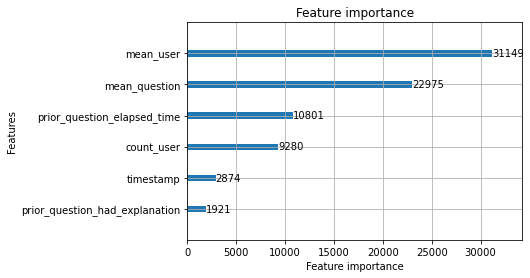

In [75]:
lgb.plot_importance(clf)
plt.show()

<h2> Submission </h2>

In [76]:
import time 
import riiideducation

env = riiideducation.make_env()

In [77]:
iter_test = env.iter_test()

In [78]:
start_time=time.time()
max_time=8*60*60
for (test_df, sample_prediction_df) in iter_test:
    duration = time.time()-start_time
    if duration > max_time :
        test_df = test_df[test_df['content_type_id'] == 0]
        test_df['answered_correctly'] = 0.5
        env.predict(test_df[['row_id', 'answered_correctly']])
    else :
        y_preds = []
        test_df["prior_question_had_explanation"] = test_df["prior_question_had_explanation"].fillna(False).\
astype('int8')
        test_df=pd.concat([test_df.reset_index(drop=True),question_df.reindex(test_df["content_id"].values).\
               reset_index(drop = True)],axis=1)
        test_df['tags'].fillna(1,inplace = True)
        test_df = test_df.merge(users,how='left',left_on=["user_id","tags"],right_index=True)
        test_df=pd.concat([test_df.reset_index(drop=True),question.reindex\
                       (test_df['content_id'].values).reset_index(drop=True)],axis=1)
        
        #test_df['tags'].fillna(40,inplace=True)
        #test_df['part'].fillna(1,inplace=True)
        #test_df = test_df.merge(users,how='left',left_on=['user_id','tags'],right_index=True)
        #test_df=pd.concat([test_df.reset_index(drop=True),question.reindex(test_df['content_id'].values).\
             #reset_index(drop=True)],axis=1)
    
    
        #test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(value = False).astype(bool)
        #test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].astype(np.int8)
        test_df = test_df.replace([np.inf, -np.inf], np.nan)
        test_df["mean_user"].fillna(0.5,inplace=True)
        test_df["mean_question"].fillna(0.5,inplace=True)
        test_df["count_user"].fillna(1,inplace=True)
        test_df.fillna(0,inplace=True)
        #test_df.fillna(value=0.5, inplace = True)
        #for model in mdls:
            #y_pred = model.predict(test_df[features].values)
            #y_preds.append(y_pred)

        #y_preds = sum(y_preds) / len(y_preds)
        test_df['answered_correctly'] = clf.predict(test_df[features])
        env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])